In [1]:
import os, sys
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# To find local version of the library
sys.path.append(ROOT_DIR)

import numpy as np
from pprint import pprint
import random
import torch
from torchvision import transforms

from utils.dataloader import SVHNDataset
from utils.dataloader import prepare_dataloaders
from utils.transforms import FirstCrop, Rescale, RandomCrop, ToTensor
from utils.misc import load_obj
from utils.visualization import visualize_sample

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


In [2]:
# Fix seed
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [3]:
train_metadata = ROOT_DIR + '/data/SVHN/train_metadata_split.pkl'
train_extra_metadata = ROOT_DIR + '/data/SVHN/train_extra_metadata_split.pkl'

metadata_train = load_obj(train_metadata)
metadata_train_extra = load_obj(train_extra_metadata)

datadir = ROOT_DIR + '/data/SVHN/'

firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()

transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                to_tensor])


## Visualize samples

In [4]:
traindata = SVHNDataset(datadir, train_metadata)
trainextradata = SVHNDataset(datadir, train_extra_metadata)

Image index in dict: 224047


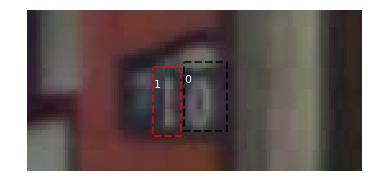

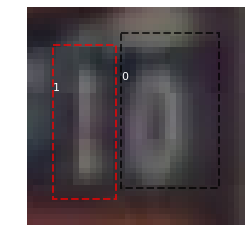

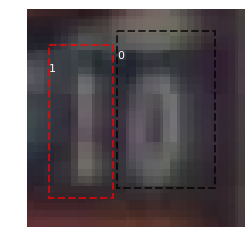

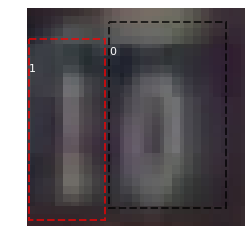

In [5]:
firstcrop = FirstCrop(0.3)
rescale = Rescale((64, 64))
random_crop = RandomCrop((54, 54))
to_tensor = ToTensor()

dataset = trainextradata
transform = transforms.Compose([firstcrop,
                                rescale,
                                random_crop,
                                ])

index = np.random.randint(len(dataset))
print('Image index in dict: {}'.format(index))
sample = dataset[index] 
visualize_sample(sample)

for i, tsfrm in enumerate([firstcrop, rescale, random_crop]):
    
    sample = tsfrm(sample)
    visualize_sample(sample)


## Get useful insight into data

In [6]:
# Explore train data
n_digits_hist_train = np.zeros(7)
n_digits_train = 0
for ii in metadata_train:
    n_digits = int(len(metadata_train[ii]['metadata']['label']))
    n_digits_train += n_digits
    if n_digits < 6:
        n_digits_hist_train[n_digits] += 1
    else:
        n_digits_hist_train[6] += 1

print('total number of digits train: {}'.format(n_digits_train))
print('total number of sequences train: {}'.format(sum(n_digits_hist_train)))
        
# Explore train + extra data
n_digits_hist_train_extra = np.zeros(7)
n_digits_train_extra = 0
for ii in metadata_train_extra:
    n_digits = int(len(metadata_train_extra[ii]['metadata']['label']))
    n_digits_train_extra += n_digits
    if n_digits < 6:
        n_digits_hist_train_extra[n_digits] += 1
    else:
        n_digits_hist_train_extra[6] += 1

print('total number of digits train + extra: {}'.format(n_digits_train_extra))
print('total number of sequences train + extra: {}'.format(sum(n_digits_hist_train_extra)))


total number of digits train: 73257
total number of sequences train: 33402.0
total number of digits train + extra: 604388
total number of sequences train + extra: 235755.0


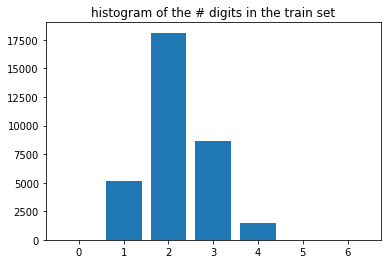

In [7]:
plt.bar(np.arange(len(n_digits_hist_train)), n_digits_hist_train)
plt.title('histogram of the # digits in the train set')
plt.show()


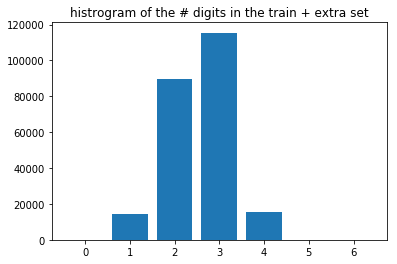

In [8]:
plt.bar(np.arange(len(n_digits_hist_train_extra)), n_digits_hist_train_extra)
plt.title('histrogram of the # digits in the train + extra set')
plt.show()


In [9]:
# Sanity check for total digits

# train
tot = 0
for ii, jj in enumerate(n_digits_hist_train):
    tot += ii*jj
    
print(tot)

# train + extra
tot = 0
for ii, jj in enumerate(n_digits_hist_train_extra):
    tot += ii*jj
    
print(tot)


73257.0
604388.0


## Train

In [10]:
# Get smallest dimensions of images possible
# Slow since you have to load every image into memory
im_width = []
im_height =  []
for jj in range(len(traindata)):
    
    shape = np.asarray(traindata[jj]['image']).shape
    im_height.append(shape[0])
    im_width.append(shape[1])
    
im_width = np.asarray(im_width)
im_height = np.asarray(im_height)


In [11]:
# Explore dataset for cleaning
# Minimum width and height of images
print('minimum image width: {}'.format(np.min(im_width)))
print('minimum image height: {}'.format(np.min(im_height)))

total = np.sum(np.logical_or(im_height < 28, im_width < 28))

print('total number of image in dataset: {}'.format(len(traindata)))
print('total number of images that are too small: {}'.format(total))


minimum image width: 25
minimum image height: 12
total number of image in dataset: 33402
total number of images that are too small: 5504


Sample
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=37x12 at 0x12F62BBA8>,
 'metadata': {'boxes': array([[ 9, 17,  1, 12],
       [19, 28,  1, 12]]),
              'filename': '/Users/margauxluck/Desktop/digit-detection/data/SVHN/train/1814.png',
              'labels': [1, 3]}}
Image shape: (12, 37, 3)


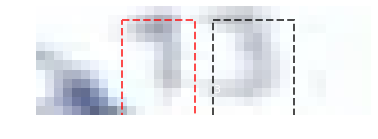

In [12]:
# Show sample image that is too small

index = np.argmin(im_height)
sample = traindata[index]
visualize_sample(sample)

print('Sample')
pprint(sample)

print('Image shape: {}'.format(np.asarray(sample['image']).shape))


## Train + Extra

In [13]:
# Get smallest dimensions of images possible
# Slow since you have to load every image into memory
im_width = []
im_height =  []
for jj in range(len(trainextradata)):
    
    shape = np.asarray(trainextradata[jj]['image']).shape
    im_height.append(shape[0])
    im_width.append(shape[1])
    
im_width = np.asarray(im_width)
im_height = np.asarray(im_height)


In [14]:
# Explore dataset for cleaning
# Minimum width and height of images
print('minimum image width: {}'.format(np.min(im_width)))
print('minimum image height: {}'.format(np.min(im_height)))

total = np.sum(np.logical_or(im_height < 28, im_width < 28))

print('total number of image in dataset: {}'.format(len(traindata)))
print('total number of images that are too small: {}'.format(total))


minimum image width: 22
minimum image height: 12
total number of image in dataset: 33402
total number of images that are too small: 15575


Sample
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=37x12 at 0x12D3F69B0>,
 'metadata': {'boxes': array([[ 9, 17,  1, 12],
       [19, 28,  1, 12]]),
              'filename': '/Users/margauxluck/Desktop/digit-detection/data/SVHN/train/1814.png',
              'labels': [1, 3]}}
Image shape: (12, 37, 3)


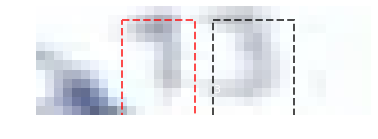

In [15]:
# Show sample image that is too small

index = np.argmin(im_height)
sample = trainextradata[index]
visualize_sample(sample)

print('Sample')
pprint(sample)

print('Image shape: {}'.format(np.asarray(sample['image']).shape))
